# Import and functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import ndimage
import pandas as pd
import os
import math


%matplotlib inline

In [2]:
import import_ipynb
try:
    os.chdir('Modules')
except:
   os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\retina_python\\Modules')
    
from time_shifted_PID import MIfunc
from time_shifted_PID import EqualState
# from StimulusnResponse import SSG
from Spike_Generation import SG
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import NL

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from Spike_Generation.ipynb


In [3]:
def NGD_TK(T, m, n, alpha, beta, g, tau_y):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    y = np.zeros_like(x)
    z = np.zeros_like(x)
    
    for i in range(len(T)):
        y[i] = y[i-1] + dt*(-alpha*y[i-1]+m*x[i-1]-n*z[i-1])
        z[i] = z[i-1] + dt*( -beta*z[i-1]+g*y[i-1])
    return y[:len(T):50], z[:len(T):50]

In [4]:
# using numpy's histogram2d to calculate the mutual information between two sequences
def mi_quick(a,b,d,bn=25):
    if d>0: xy,_,_ = np.histogram2d(a[d:],b[:-d],bn)
    elif d<0: xy,_,_ = np.histogram2d(a[:d],b[-d:],bn)
    else: xy,_,_ = np.histogram2d(a,b,bn)
    xy /= np.sum(xy)
    px = [np.array([max(x,1e-100) for x in np.sum(xy,axis=0)])]
    py = np.transpose([[max(x,1e-100) for x in np.sum(xy,axis=1)]])
    nxy = (xy/px)/py
    nxy[nxy==0] = 1e-100
    return np.sum(xy*np.log2(nxy))

# NGD

In [6]:
m = 16.416565
n =	500
alpha = 41.464099
beta = 2.088120
g =  1729.111153/n
tau_y = 0.051583

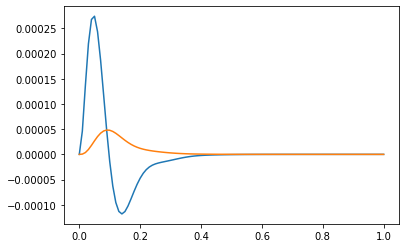

In [7]:
dt = 0.01
TKaxis = np.arange(101)*dt

k_E, k_S = NGD_TK(TKaxis, m, n, alpha, beta, g, tau_y)
# y_TK, w_TK = NGD_TK(TKaxis, *[2.67758918, 1.00000000, 1.17089092e+01, 4.69398540, 4.73653606e+02, 2.45547756e-02])
plt.plot(TKaxis, k_E)
plt.plot(TKaxis, k_S)

In [8]:
tot = 300
tAxis = np.arange(0,tot,dt)
# OU ; input
tau = 1
D = 1
OU=np.zeros(len(tAxis))
mu, sigma = 0, 1
for i in range(len(tAxis)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+np.sqrt(D*dt)*np.random.normal(mu,sigma)
# filtering for OUSmoothed
Fc = 1
b, a = signal.butter(2, 2*Fc*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)
x = (LPOU-np.mean(LPOU))/np.std(LPOU)

In [9]:
contrast = 0.2
mean = 10
baseOutput = -np.convolve(np.hstack((np.zeros(len(k_E)), x))*contrast*mean+mean, k_E, 'full')[len(k_E):len(k_E)+len(x)]

(0.0, 5000.0)

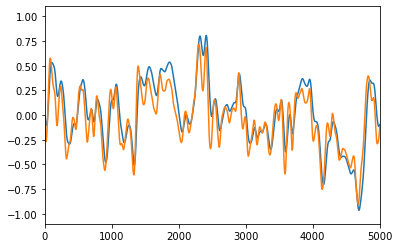

In [10]:
#Using notation of: J Neurophysiol 98: 1287–1296, 2007.
#Contrast Adaptation in a Nonadapting LGN Model
#Kate S. Gaudry and Pamela Reinagel

s = (x-min(x)) / (max(x)-min(x)) *2-1
g = (baseOutput-min(baseOutput))/(max(baseOutput)-min(baseOutput)) *2-1
# g = baseOutput/max(baseOutput)

plt.plot(-s)
plt.plot(g)
plt.xlim(0,5000)

In [17]:
theta_star = 0

# GC

In [11]:
#Gain control function
def gain_func(v):
    try: # if v is an ndarray
        v[v < 0] = 0
    except: # if v is a variable
        if v < 0 : return 1
    return 1/(1+v**4)
    
def AddGainControl(r, B, tau):
    decay = np.exp(-(np.arange(0,1,dt)+dt)/tau)
    # plt.plot(np.arange(0,1,dt)+dt,decay)

    output = np.zeros_like(r)
    gain = np.zeros_like(r)
    for i in np.arange(1,r.shape[0]):
        gain[i] = gain_func(np.sum(B*decay[:min(i,len(decay))]*output[i:max(0, i-len(decay)):-1]*dt) )
        opi = gain[i]*r[i]
        output[i] = opi
    output[output<0] = 0
    return  output, gain

In [12]:
B = 3000 #To tune altitude of gain control (D=1/T)
tau = 0.1

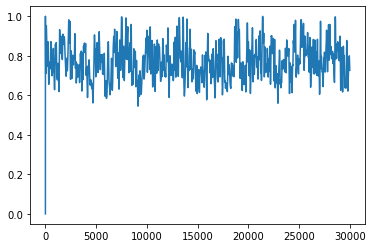

In [21]:
GC_output, gain = AddGainControl(-baseOutput, B, tau) # GC after rectifier
plt.plot(gain) # make sure the value of gain is good

GC_output = -GC_output

# SFB

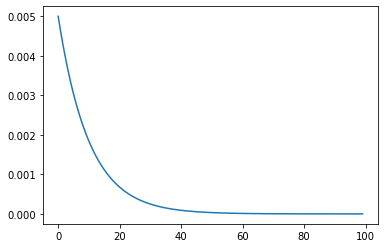

In [15]:
tau_P = 0.1 #s
sigma_b = 0.005
expDecay = np.exp(-np.arange(0,1,dt)/tau_P)*sigma_b
plt.plot(expDecay)

In [16]:
def SFB(input, expDecay, theta):
    test = 0
    h = input.copy()
    rstate = np.zeros_like(baseOutput)
    for i in range(len(h)):
        if h[i] > theta:
            rstate[i] = 1
            h[i+1:min(i+len(expDecay),len(h))] -= expDecay[1:min(len(expDecay),len(h)-i)]
    return rstate, h

In [18]:
theta = np.mean(baseOutput)+theta_star*np.std(baseOutput)
rstate, h = SFB(baseOutput, expDecay, theta)

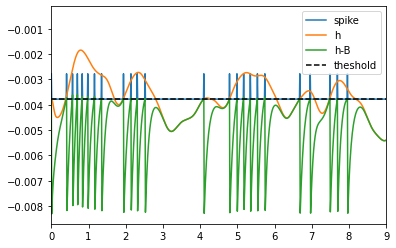

In [23]:
plt.plot(tAxis,rstate*sigma_b/5+theta, label = 'spike')

plt.plot(tAxis,baseOutput, label = 'h')
# plt.plot(tAxis,GC_output, label = 'h')
plt.plot(tAxis,h, label = 'h-B')
plt.plot(tAxis,np.ones_like(baseOutput)*theta, 'k--', label = 'theshold')
plt.xlim(0,9)
plt.legend()

# LNK

In [ ]:
# four states kinetic model
# using the same notation as Ozuysal
# Eqn(11) in "Experimental Procedure" section

def kinetic(u,para,dt):
    ka  = para[0]
    kfr = para[1]
    kfi = para[2]
    ksr = para[3]
    ksi = para[4]
#   initial conditions for the four states
    p1 = 1.0
    p2 = 0
    p3 = 0.0
    p4 = 0.0

    p1r = []
    p2r = []
    p3r = []
    p4r = []
#
# 
#
    for i in range(len(u)):
        dp1 = (-u[i]*ka*p1  + kfr*p3)*dt
        dp2 =  (u[i]*ka*p1     - kfi*p2)*dt
        dp3 =  (kfi*p2 - (kfr+ksi)*p3 + u[i]*ksr*p4)*dt
        dp4 =  (ksi*p3 - u[i]*ksr*p4)*dt
    
        p1 = p1 + dp1
        p2 = p2 + dp2
        p3 = p3 + dp3
        p4 = p4 + dp4
    
        p1r.append(p1)
        p2r.append(p2)
        p3r.append(p3)
        p4r.append(p4)
        
# turn list into numpy arrays
    p1r = np.array(p1r)
    p2r = np.array(p2r)
    p3r = np.array(p3r)
    p4r = np.array(p4r)
    return (p1r,p2r,p3r,p4r)

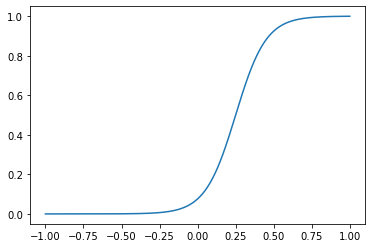

In [101]:
# Nonlinearity function
midpoint = 0.25 # position of the mid point of the nonlinear function (tanh)
DR = 5 # dynamical range (?) of the nonlinear function (tanh)
dummy = np.linspace(-1,1,1000)
plt.plot(dummy, (np.tanh((dummy-midpoint)*DR)+1)/2)

(0.0, 5000.0)

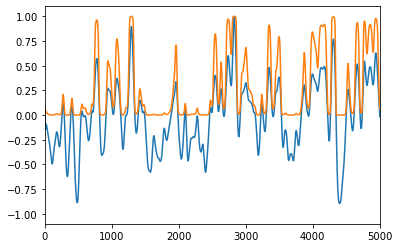

In [102]:
# testing of u from g
u = (np.tanh((g-midpoint)*DR)+1)/2
plt.plot(g)
plt.plot(u)
plt.xlim(0,5000)

[1. 1. 1. ... 1. 1. 1.]


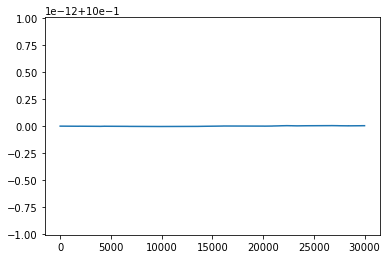

In [103]:
# using the same notation as Ozuysal 

para = [60,20,3,0.03,1.0] # parameters for the five rates from Figure 2
midpoint= 0.0 # this is similar to the threshold of Leo's code?

u = NL(g,midpoint)
R,A,I1,I2=kinetic(u,para,dt)

# checking if the sum of the pools are conserved.
plt.plot(R+A+I1+I2)
print(R+A+I1+I2)

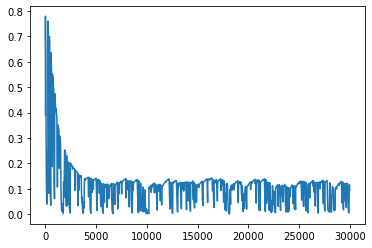

In [104]:
# Action pool = output of the system
plt.plot(A)

(0.0, 10000.0)

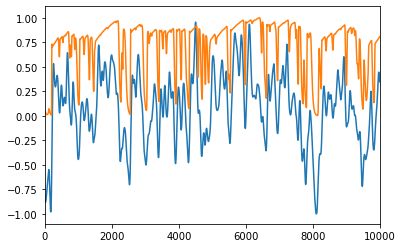

In [105]:
# remove the first 10000 (10 sec) points for transients
ss = x[10000:]
rr = A[10000:]
plt.plot(-ss/ss.max())
plt.plot(rr/rr.max())
plt.xlim(0,10000)

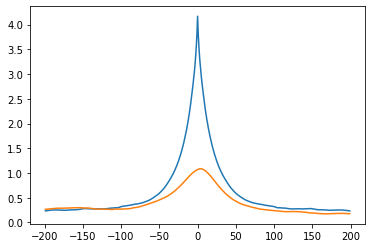

In [106]:
# check if there is anticipation by TLMI

dms = range(-199,200)
mi_ssss = [mi_quick(ss,ss,d) for d in dms]
mi_ssrr = [mi_quick(ss,rr,d) for d in dms]
plt.plot(dms,mi_ssss)
plt.plot(dms,np.array(mi_ssrr))

In [107]:
print('Anticipation horizon =',dms[np.argmax(mi_ssrr)]*dt,'second')

Anticipation horizon = 0.04 second
